# Naive Bayes classifier for Fake News recognition
Fake news are defined by the New York Times as *"a made-up story with an intention to deceive"*, with
the intent to confuse or deceive people. They are everywhere in our daily life, and come especially from
social media platforms and applications in the online world. Being able to distinguish fake contents form
real news is today one of the most serious challenges facing the news industry.  

[Naive Bayes classifiers][1] are powerful algorithms that are used for text data analysis and are connected
to classification tasks of text in multiple classes.  
The goal of the project is to implement a __Multinomial Naive Bayes classifier__ in `R` and test its perfor-
mances in the classification of social media posts.
The suggested data set is available on [Kaggle][2]

[1]: https://nlp.stanford.edu/IR-book/pdf/13bayes.pdf "C. D. Manning, Chapter 13, Text Classification and Naive Bayes, in Introduction to Information Retrieval, Cambridge University Press, 2008."
[2]: https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv

## Import useful libraries

In [1]:
library(tidyverse)
library(evaluate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Import dataset

In [2]:
df <- read_csv('NaiveBayesMNC/train_corrected2.csv', col_types = 'icc')
head(df, 10)

label_dict <- c('True', 'Not-Known', 'Mostly-True', 'Half-True', 'False', 'Barely-True')
names(label_dict) <- c('5', '4', '3', '2', '1', '0')

Labels,Text,Text_Tag
<int>,<chr>,<chr>
1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
2,The economic turnaround started at the end of my term.,"economy,jobs"
5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education
0,Jim Dunnam has not lived in the district he represents for years now.,candidates-biography
2,"I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate.",ethics
2,"However, it took $19.5 million in Oregon Lottery funds for the Port of Newport to eventually land the new NOAA Marine Operations Center-Pacific.",jobs


## Define useful functions

In [3]:
confusion_matrix <- function( predictions, true_labels) {
    
    # Function that evaluates the confusion matrix given the predicted labels and the true labels
    
    confusion_matrix <- matrix(rep(0, length(unique(true_labels))^2), ncol=length(unique(true_labels)))
    colnames(confusion_matrix) <- paste('t', label_dict, sep='_')
    rownames(confusion_matrix) <- paste('p', label_dict, sep='_')
    N <- table(true_labels)
    names(N) <- label_dict[names(N)]

    for(j in 1:ncol(confusion_matrix)) {
        for( i in 1:nrow(confusion_matrix)){
            confusion_matrix[i,j] <- sum(predictions==names(label_dict)[i] & true_labels==names(label_dict)[j])
        } 
        # normalize over that class
        confusion_matrix[,j] <- confusion_matrix[,j] / N[label_dict[j]]

    }

    return(confusion_matrix)
}

In [4]:
plot_confmat <- function(conf_matrix, title) {

    # Function which plots the confusion matrix given the confusion matrix data

    df_plt <- as.data.frame(conf_matrix) %>% mutate(., p=rownames(.)) %>% pivot_longer(., cols=colnames(.)[-7], names_to='t', values_to='acc')
    plt <- ggplot(df_plt, aes(x=t, y=p)) +
                geom_raster(aes(fill=acc)) +
                geom_text(aes(label=format(acc, digit=3))) +
                labs(title=title, x='True labels', y='Predicted labels') +
                theme(plot.title=element_text(hjust=0.5))
    return(plt)
}

In [5]:
accuracy <- function(predictions, true_labels) {

    #evaluate the accuracy by: acc = true predicted / tot documents

    predictions <- as.numeric(predictions)
    true_labels <- as.numeric(true_labels)
    sum(predictions==true_labels) / length(predictions)
}

In [6]:
extract_alnum <- function(documents, unique=TRUE, filter_n=0, freq_n = 0) {

    # function that extract the vocabulary  of a list of documents
    # returns the list of all the alpha numeric elemets which are in the documents
    # the numeric values are substitute with the word "isnumeric"

    #ARGS: unique = TRUE --> return the list of the unique words
        #  filter_n --> return the list of the words which length >= filter_n
        #  freq_n   --> return the list of the words which frequence <= freq_n

    words <- str_replace_all(documents, "[:digit:]+[.,]*[:digit:]*", "isnumeric")
    words <- unlist(str_extract_all(words, "[:alnum:]+"))
    #words <- words[words!='']
    words <- casefold(words, upper = FALSE)
    #words <- words[!is.na(words)]
    if(filter_n){
        words <- words[nchar(words)>filter_n]
    }

    if(freq_n){
        freq <- table(words)
        words <- names(freq)[freq<freq_n]
    }

    if(unique) return(unique(words))
    else return(words)

}

## Multinomial NB classifier implementation

In [7]:
multinomNBC.fit <- function(documents, labels, filter_n=0, freq_n=0) {
    
    # Function to train --> evaluate the prior and the likelihood given a set of documents
    # ARGS: documents must be a list
        #   filter_n --> the vocabulary used cointains the words which length >= filter_n
        #   freq_n   --> the vocabulary used cointains the words which frequence <= freq_n

    # Return a list with the values of the likelihood prior and the vocabulary used
    
    log.like  <- list()

    # extract vocabulary
    V <- extract_alnum(documents[[1]],filter_n = filter_n, freq_n = freq_n)
    N <- length(documents[[1]])
    log.prior <- log(table(labels)) - log(N)

    for(l in unique(labels[[1]])) {
        
        text <- extract_alnum(documents[labels==l], unique=FALSE)
        freq <- table(c(text, V))
        log.like[[as.character(l)]] <- log(freq) - log(sum(freq))
    }

    return(list(log.likelihood=log.like, log.prior=log.prior, vocabulary=V[order(V)]))
}

In [8]:
multinomNBC.predict <- function(doc, log.prior, log.likelihood, voc){

    # Function which estimate the label of a given single document

    text <- extract_alnum(doc, unique=FALSE)
    freq <- table(text)[voc]
    freq <- freq[!is.na(freq)]
    #print(freq)
    scores <- rep(0, length(log.prior))
    names(scores) <- dimnames(log.prior)$Labels

    for( l in names(scores)) {
        scores[l] <- log.prior[l] + sum(log.likelihood[[l]][dimnames(freq)$text] * freq)
    }
    
    return(names(scores)[which.max(scores)])
    # return(scores)
}

# predict a list of documents
multinomNBC.predict <- Vectorize(multinomNBC.predict, vectorize.args='doc', USE.NAMES=FALSE)

### Let's try it

In [118]:
nDoc <- dim(df)[1]
test <- 2000
results <- multinomNBC.fit(df[(test+1):nDoc, 2], df[(test+1):nDoc, 1])
pred    <- multinomNBC.predict(df[1:test, 2][[1]], results$log.prior, results$log.likelihood, results$vocabulary)

accuracy(pred, df[1:test, 1][[1]])
cat('Prior of classes:\n')
exp(results$log.prior)

[1] 0.234

Prior of classes:


Labels
         0          1          2          3          4          5 
0.16398597 0.19204257 0.21018261 0.19022856 0.08102552 0.16253477 

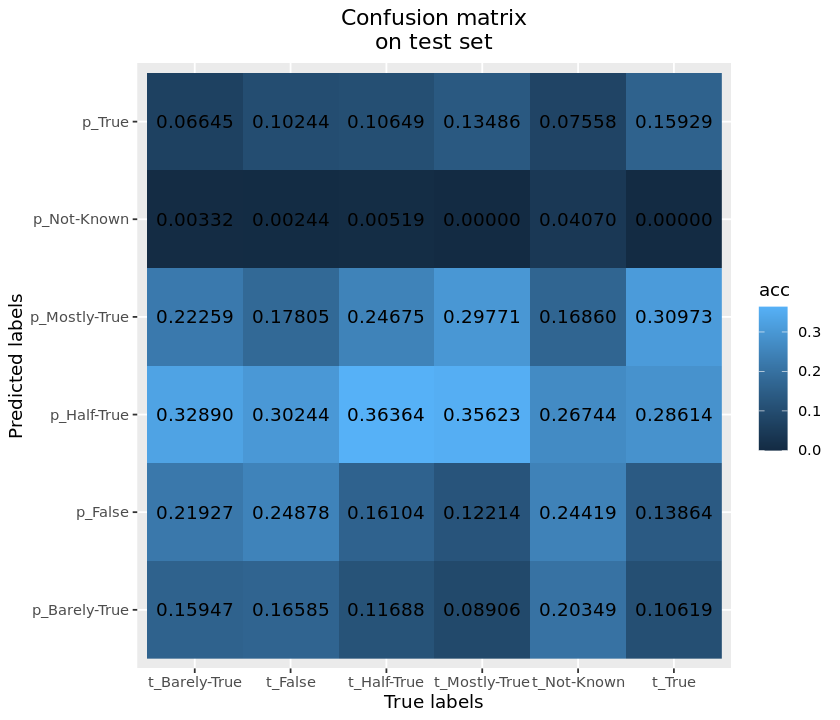

In [119]:
options(repr.plot.width=7, repr.plot.height=6)
conf_mat_s <- confusion_matrix(pred, df[1:test, 1][[1]])
plt <- plot_confmat(conf_mat, 'Confusion matrix\non test set')
plt
ggsave('conf_matrix_letstryit_test.pdf', plt, width=7, height=6)

## Feature reduction

### Naive feature reduction

Now we try to filter our vocabulary by word length and frequency of the word. Results will not be very satisfying, thus we will drop this method.  
First we declare some useful function. They are an optimized and extended version of the previous ones, capable of filtering the vocabulary as described above.

In [21]:
extract_alnum2 <- function(documents, unique=TRUE, filter_f=`>`, filter_n=0, freq_f=`<`, freq_n = 0) {

    # Function son of the extract_alnum but in which it can be selected the type of filter and frequence

    words <- str_replace_all(documents, "[:digit:]+[.,]*[:digit:]*", "isnumeric")
    words <- unlist(str_extract_all(words, "[:alnum:]+"))
    words <- casefold(words, upper = FALSE)
    
    if(filter_n){
        words <- words[filter_f(nchar(words), filter_n)]
    }

    if(freq_n){
        freq <- table(words)
        words <- names(freq)[freq_f(freq, freq_n)]
    }

    if(unique) return(unique(words))
    else return(words)

}

multinomNBC.fit2 <- function(documents, labels, V=NULL, ...) {

    # extract vocabulary
    if(is.null(V)) {
        V <- extract_alnum2(documents[[1]], unique=TRUE, ...)
    }
    N <- length(documents[[1]])
    unique_labels <- unique(labels[[1]])
    log.prior <- log(table(labels)) - log(N)

    dimnames <- list(unique_labels, V)
    log.like  <- matrix(nrow=length(unique_labels), ncol=length(V), dimnames=dimnames)

    for(l in unique_labels) {
        
        text <- extract_alnum2(documents[labels==l], unique=FALSE, ...)
        freq <- table(c(text, V))[V]
        log.like[as.character(l), ] <- log(freq) - log(sum(freq))
    }

    return(list(log.likelihood=log.like, log.prior=log.prior, vocabulary=V[order(V)]))
}

multinomNBC.predict2 <- function(doc, log.prior, log.likelihood, voc){

    text <- extract_alnum2(doc, unique=FALSE)
    freq <- table(text)[voc]
    freq <- freq[!is.na(freq)]
    #print(freq)
    scores <- rep(0, length(log.prior))
    names(scores) <- dimnames(log.prior)$Labels

    for( l in names(scores)) {
        scores[l] <- log.prior[l] + sum(log.likelihood[l, dimnames(freq)$text] * freq)
    }
    
    return(names(scores)[which.max(scores)[[1]]])
    #return(scores)
}

multinomNBC.predict2 <- Vectorize(multinomNBC.predict2, vectorize.args='doc', USE.NAMES=FALSE)

And then we run fit and predictions over a grid of parameters in order to find the best combination.

In [24]:
evaluate::inject_funs(
  flush.console = function() { base::flush.console(); evaluate::flush_console() },
  flush = function(con) { base::flush(con); evaluate::flush_console() }
)


freqs <- c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90)
filters <- c(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
nDoc <- dim(df)[1]
test <- 2000
data_test <- data.frame(filters=rep(filters, each=length(freqs)*4), freqs=rep(freqs, length(filters), each=4), 
                               filter_f=rep(c('>', '<='), length(freqs)*length(filters),each=2), 
                               freq_f  =rep(c('>', '<='), length(freqs)*length(filters)*2), acc=rep(0, length=length(freqs)*length(filters)*4))
data_train <- data_test
count <- 0

for(filter_f in c('>', '<=')) {
    for(freq_f in c('>', '<=')) {
        for(freq_n in freqs) {
            for(filter_n in filters) {
                
                results    <- multinomNBC.fit2(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], filter_n = filter_n, freq_n = freq_n, filter_f = get(filter_f), freq_f = get(freq_f))
                pred_test  <- multinomNBC.predict2(df[(nDoc-test+1):nDoc, 2][[1]], results$log.prior, results$log.likelihood, results$vocabulary)
                pred_train <- multinomNBC.predict2(df[1:(nDoc-test), 2][[1]], results$log.prior, results$log.likelihood, results$vocabulary)
                
                # test set accuracy
                data_test[data_test$filters==filter_n & data_test$freqs==freq_n &
                          data_test$filter_f==filter_f & data_test$freq_f==freq_f, 'acc'] <- accuracy(pred_test, df[(nDoc-test+1):nDoc, 1][[1]])

                # training set accuracy
                data_train[data_train$filters==filter_n & data_train$freqs==freq_n &
                           data_train$filter_f==filter_f & data_train$freq_f==freq_f, 'acc'] <- accuracy(pred_train, df[1:(nDoc-test), 1][[1]])
                     
                count <- count + 1
                cat(sprintf('\r%.2f%% done', count*100/(length(freqs)*length(filters)*4)))
                flush_console()
            }
        }
    }
}

100.00% done

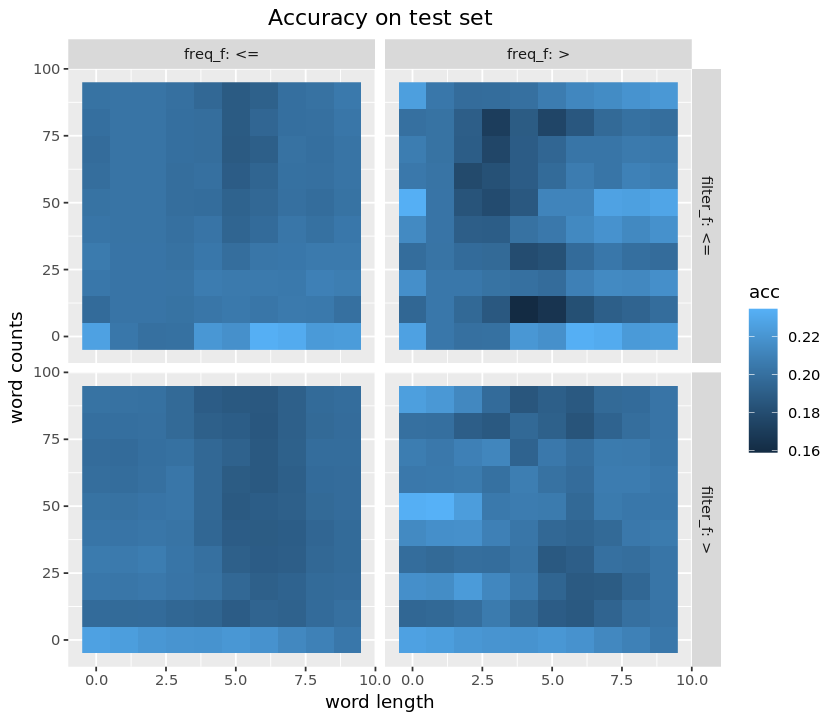

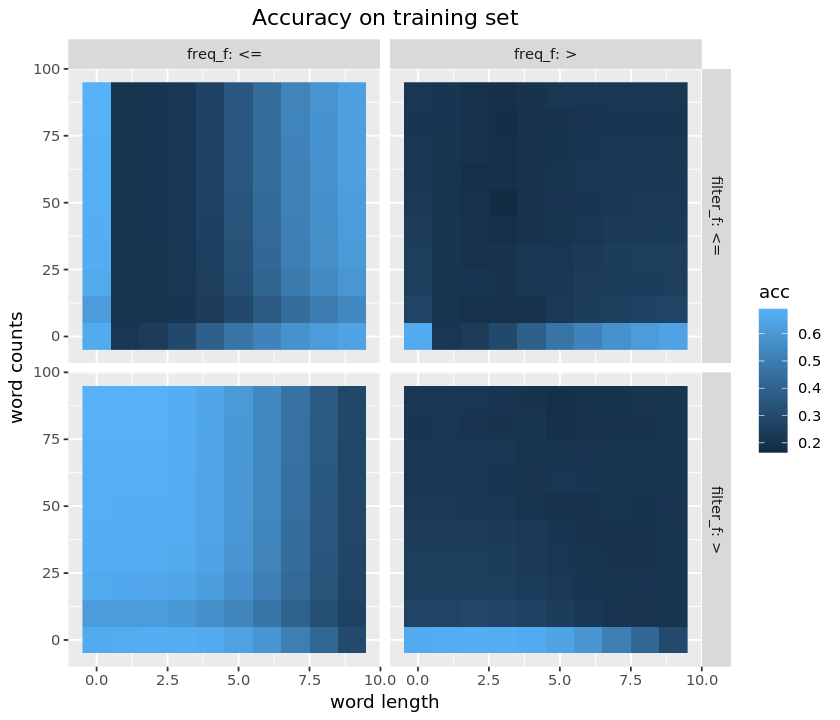

In [25]:
# accuracy on test set
plt_test <- ggplot(data_test, aes(x=filters, y=freqs)) +
            geom_raster(aes(fill=acc)) +
            facet_grid(filter_f ~ freq_f, labeller='label_both') +
            labs(title='Accuracy on test set', x='word length', y='word counts') +
            theme(plot.title=element_text(hjust=0.5))
plt_test
ggsave('accuracy_test_nfr.pdf', plt_test, width=7, height=6)

# accuracy on traiinng set
plt_train <- ggplot(data_train, aes(x=filters, y=freqs)) +
             geom_raster(aes(fill=acc)) +
             facet_grid(filter_f ~ freq_f, labeller='label_both') +
             labs(title='Accuracy on training set', x='word length', y='word counts') +
             theme(plot.title=element_text(hjust=0.5))
plt_train
ggsave('accuracy_training_nfr.pdf', plt_train, width=7, height=6)


In [26]:
head(data_test[order(data_test$acc, decreasing=TRUE),], 10)
head(data_train[order(data_train$acc, decreasing=TRUE),], 20)
data_train[1,]

,filters,freqs,filter_f,freq_f,acc
,<dbl>,<dbl>,<chr>,<chr>,<dbl>
61,1,50,>,>,0.2345
21,0,50,>,>,0.2335
23,0,50,<=,>,0.2335
243,6,0,<=,>,0.2335
244,6,0,<=,<=,0.2335
283,7,0,<=,>,0.2315
284,7,0,<=,<=,0.2315
383,9,50,<=,>,0.2285
303,7,50,<=,>,0.2270


,filters,freqs,filter_f,freq_f,acc
,<dbl>,<dbl>,<chr>,<chr>,<dbl>
34,0,80,>,<=,0.6905309
36,0,80,<=,<=,0.6905309
38,0,90,>,<=,0.6896844
40,0,90,<=,<=,0.6896844
74,1,80,>,<=,0.6895634
78,1,90,>,<=,0.6894425
118,2,90,>,<=,0.6894425
114,2,80,>,<=,0.6890797
30,0,70,>,<=,0.6882332


,filters,freqs,filter_f,freq_f,acc
,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,0,0,>,>,0.6699722


In [65]:
# best parameters estimates and confusion matrix for test set
max_params_test <- data_test[which.max(data_test$acc),]
cat('Parameters with best accuracy on test set:\n')
max_params_test
results_test <- multinomNBC.fit2(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], filter_n = max_params_test[['filters']], freq_n = max_params_test[['freqs']], filter_f = get(max_params_test[['filter_f']]), freq_f = get(max_params_test[['freq_f']]))
pred_test    <- multinomNBC.predict2(df[(nDoc-test+1):nDoc, 2][[1]], results_test$log.prior, results_test$log.likelihood, results_test$vocabulary)

conf_matrix_test_nfr <- confusion_matrix(pred_test, df[(nDoc-test+1):nDoc, 1][[1]])
conf_matrix_test_nfr

Parameters with best accuracy on test set:


,filters,freqs,filter_f,freq_f,acc
,<dbl>,<dbl>,<chr>,<chr>,<dbl>
61,1,50,>,>,0.2345


,t_True,t_Not-Known,t_Mostly-True,t_Half-True,t_False,t_Barely-True
p_True,0.13707165,0.07303371,0.128342246,0.096296296,0.10769231,0.05120482
p_Not-Known,0.00623053,0.02808989,0.005347594,0.007407407,0.01025641,0.01204819
p_Mostly-True,0.33021807,0.16292135,0.286096257,0.283950617,0.21282051,0.21686747
p_Half-True,0.28971963,0.27528090,0.336898396,0.358024691,0.29743590,0.35240964
p_False,0.17133956,0.29775281,0.149732620,0.143209877,0.25384615,0.20783133
p_Barely-True,0.06542056,0.16292135,0.093582888,0.111111111,0.11794872,0.15963855


In [28]:
# best parameters estimates and confusion matrix for training set
max_params_train <- data_train[which.max(data_train$acc),]
cat('Parameters with best accuracy on train set:\n')
max_params_train
results_train <- multinomNBC.fit2(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], filter_n = max_params_train[['filters']], freq_n = max_params_train[['freqs']], filter_f = get(max_params_train[['filter_f']]), freq_f = get(max_params_train[['freq_f']]))
pred_train    <- multinomNBC.predict2(df[1:(nDoc-test), 2][[1]], results_train$log.prior, results_train$log.likelihood, results_train$vocabulary)

conf_matrix_train <- confusion_matrix(pred_train, df[1:(nDoc-test), 1][[1]])
conf_matrix_train


Parameters with best accuracy on train set:


,filters,freqs,filter_f,freq_f,acc
,<dbl>,<dbl>,<chr>,<chr>,<dbl>
34,0,80,>,<=,0.6905309


,t_True,t_Not-Known,t_Mostly-True,t_Half-True,t_False,t_Barely-True
p_True,0.6453744493,0.03313253,0.018216080,0.029685681,0.0279850746,0.038490566
p_Not-Known,0.0007342144,0.66867470,0.003140704,0.003492433,0.0006218905,0.003018868
p_Mostly-True,0.1820851689,0.09789157,0.847361809,0.174621653,0.1896766169,0.193962264
p_Half-True,0.1505139501,0.13855422,0.131281407,0.778812573,0.1853233831,0.169811321
p_False,0.0212922173,0.04367470,0.000000000,0.006402794,0.5907960199,0.028679245
p_Barely-True,0.0000000000,0.01807229,0.000000000,0.006984866,0.0055970149,0.566037736


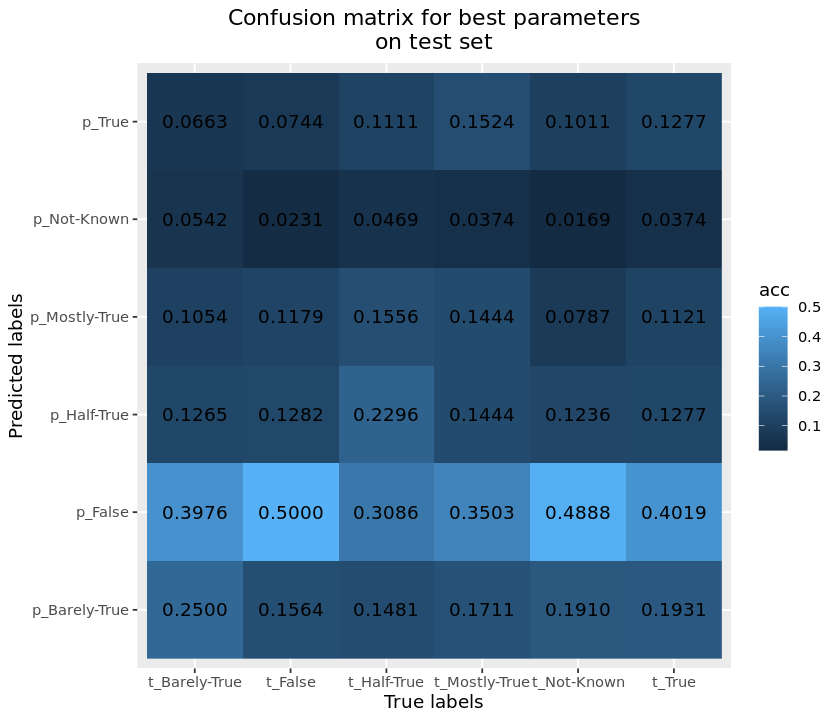

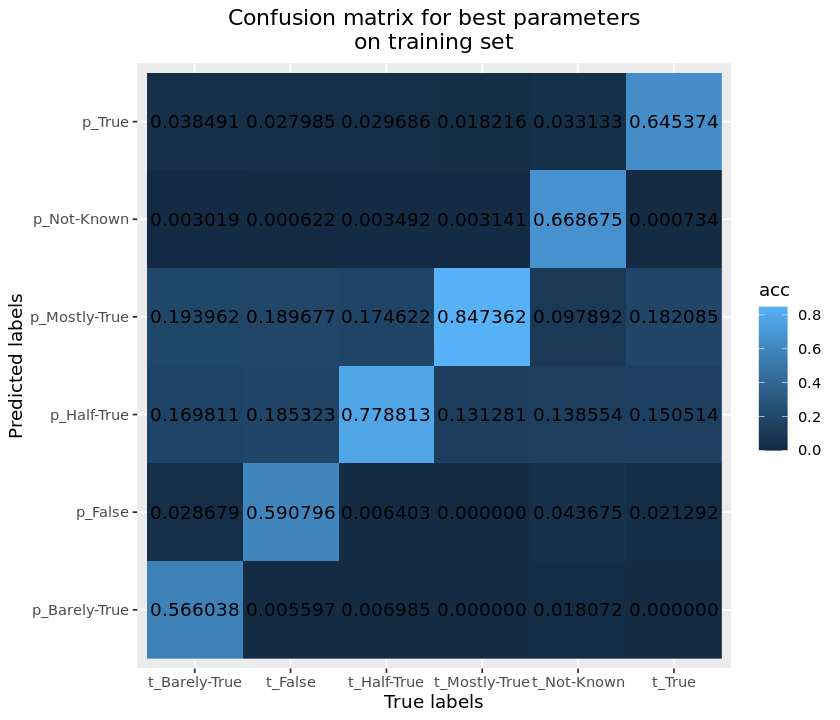

In [29]:
plt_test <- plot_confmat(conf_matrix_test_nfr, 'Confusion matrix for best parameters\non test set')
plt_test
ggsave('conf_matrix_test_nfr.pdf', plt_test, width=7, height=6)

plt_train <- plot_confmat(conf_matrix_train, 'Confusion matrix for best parameters\non training set')
plt_train
ggsave('conf_matrix_train_nfr.pdf', plt_train, width=7, height=6)


Let's compare with the case without feature reduction

,t_True,t_Not-Known,t_Mostly-True,t_Half-True,t_False,t_Barely-True
p_True,0.13707165,0.07303371,0.128342246,0.096296296,0.10769231,0.05120482
p_Not-Known,0.00623053,0.02808989,0.005347594,0.007407407,0.01025641,0.01204819
p_Mostly-True,0.33021807,0.16292135,0.286096257,0.283950617,0.21282051,0.21686747
p_Half-True,0.28971963,0.27528090,0.336898396,0.358024691,0.29743590,0.35240964
p_False,0.17133956,0.29775281,0.149732620,0.143209877,0.25384615,0.20783133
p_Barely-True,0.06542056,0.16292135,0.093582888,0.111111111,0.11794872,0.15963855


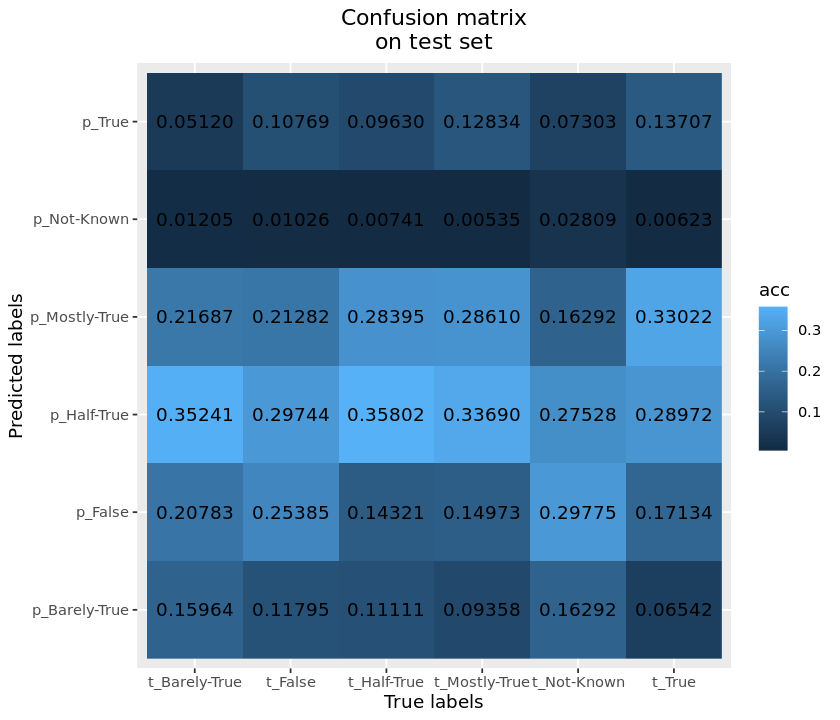

In [30]:
results_test <- multinomNBC.fit2(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1])
pred_test    <- multinomNBC.predict2(df[(nDoc-test+1):nDoc, 2][[1]], results_test$log.prior, results_test$log.likelihood, results_test$vocabulary)

conf_matrix_test <- confusion_matrix(pred_test, df[(nDoc-test+1):nDoc, 1][[1]])
conf_matrix_test

plt_test <- plot_confmat(conf_matrix_test, 'Confusion matrix\non test set')
plt_test
ggsave('conf_matrix_test.pdf', plt_test, width=7, height=6)

,t_True,t_Not-Known,t_Mostly-True,t_Half-True,t_False,t_Barely-True
p_True,0.618208517,0.05722892,0.02952261,0.032596042,0.04415423,0.042264151
p_Not-Known,0.002936858,0.38253012,0.00000000,0.001164144,0.00000000,0.002264151
p_Mostly-True,0.127753304,0.10843373,0.76130653,0.097206054,0.11256219,0.145660377
p_Half-True,0.148311307,0.17018072,0.11934673,0.789871944,0.13370647,0.153962264
p_False,0.071953010,0.17921687,0.04836683,0.051804424,0.67599502,0.061132075
p_Barely-True,0.030837004,0.10240964,0.04145729,0.027357392,0.03358209,0.594716981


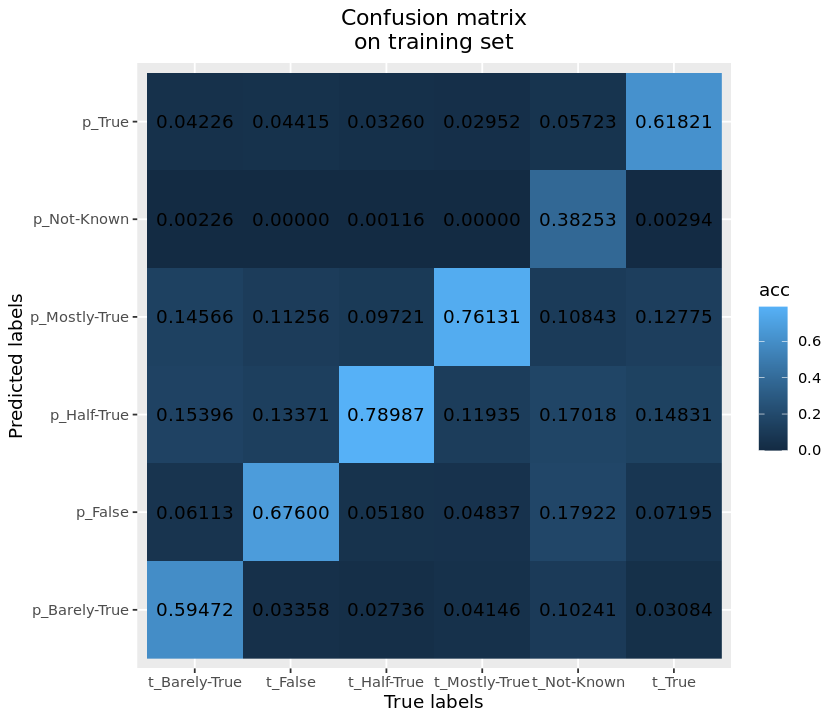

In [31]:
results_train <- multinomNBC.fit2(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1])
pred_train    <- multinomNBC.predict2(df[1:(nDoc-test), 2][[1]], results_train$log.prior, results_train$log.likelihood, results_train$vocabulary)

conf_matrix_train <- confusion_matrix(pred_train, df[1:(nDoc-test), 1][[1]])
conf_matrix_train

plt_train <- plot_confmat(conf_matrix_train, 'Confusion matrix\non training set')
plt_train
ggsave('conf_matrix_train.pdf', plt_train, width=7, height=6)


We see that there is no evidence of a gain in reducing features in this way.

### Feature reduction by Mutual Information

In [37]:
mutual_information <- function(N11,N10,N01,N00){

    # Function that evaluates the mutual information for given word and class

    N   <- N11 + N10 + N01 + N00
    N1  <- N11 + N10
    N.1 <- N11 + N01
    N0  <- N00 + N01
    N.0 <- N00 + N10

    # MI  <- N11/N * (log2(N)+log2(N11) -log2(N1)-log2(N.1)) + N01/N * log2(N*N01/(N0*N.1)) #+ N10/N * log2(N*N10/(N1*N.0)) + N00/N * log2(N*N00/(N0*N.0))
    MI  <- N11/N * (log2(N)+log2(N11) - log2(N1)- log2(N.1)) + N01/N * (log2(N)+log2(N01) - log2(N0)-log2(N.1)) + N10/N * (log2(N)+log2(N10) - log2(N1)- log2(N.0)) + N00/N * (log2(N)+log2(N00) - log2(N0)- log2(N.0))
    return(MI)
}

In [38]:
#setting the column names of the dataframe
N_11 <- c("w0","w1","w2","w3","w4","w5")
N_10 <- c("wnot0","wnot1","wnot2","wnot3","wnot4","wnot5")
N_01 <- c("notw0","notw1","notw2","notw3","notw4","notw5")
N_00 <- c("notwnot0","notwnot1","notwnot2","notwnot3","notwnot4","notwnot5")

col  <- c(sort(unique(df$Labels)), N_10, N_01, N_00)

In [39]:
#trying to build an example of dataframe for extracting all the information for the MI
voc <- extract_alnum(df[, 2][[1]], unique=TRUE)

words_df <- data.frame(matrix(nrow=length(voc[1:10]),ncol=(length(col))),row.names=voc[1:10])
colnames(words_df) <- col

#first we add N11 and N10
for (word in voc[1:10]){
    for (l in unique(df$Labels)){
        #aggiungo al elemento [word,l] il numero di documenti con label l che contengono word
        words_df[word,as.character(l)] <- sum(grepl(word,casefold(df$Text[df$Labels==l])))   #evaluate N_11
    }
    for (i in seq_along(N_10)){
        words_df[word,N_10[i]] <- sum(words_df[word,][-c(i,7:24)],na.rm=TRUE) #evaluate N_10
    }
}
#we add to the dataframe N01 and N00
for (word in voc[1:500]){
    for (i in seq_along(N_10)){

        words_df[word,N_01[i]] <- sum(words_df[-which(row.names(words_df)==word),i],na.rm=TRUE) #evaluate N_01

        words_df[word,N_00[i]] <- sum(words_df[-which(row.names(words_df)==word),-c(i,7:24)],na.rm=TRUE) #evaluate N_00
        
    }
}

In [40]:
#we try to extract the MI vocabulary
Labs <- sort(unique(df$Labels))
MI_df <- data.frame(matrix(nrow=length(voc[1:10]),ncol=(length(Labs))),row.names=voc[1:10])
colnames(MI_df) <- Labs

for (word in voc[1:500]){
    for (i in seq_along(Labs)){
        MI_df[word, i] <- mutual_information(words_df[word,i],words_df[word,i+6],words_df[word,i+12],words_df[word,i+18])
    }
}

#### Mutual information on all the vocabulary

In [41]:
# FIRST WE BUILD WORDS_DF
voc <- extract_alnum(df[, 2][[1]], unique=TRUE)

words_df <- data.frame(matrix(nrow=length(voc),ncol=(length(col))),row.names=voc)
colnames(words_df) <- col

for (word in voc){
    for (l in unique(df$Labels)){
        #aggiungo al elemento [word,l] il numero di documenti con label l che contengono word
        words_df[word,as.character(l)] <- sum(grepl(word,casefold(df$Text[df$Labels==l])))   #evaluate N_00
    }
    for (i in seq_along(N_10)){
        words_df[word,N_10[i]] <- sum(words_df[word,][-c(i,7:24)],na.rm=TRUE) #evaluate N_10
    }
}
for (word in voc){
    for (i in seq_along(N_10)){

        words_df[word,N_01[i]] <- sum(words_df[-which(row.names(words_df)==word),i],na.rm=TRUE) #evaluate N_01

        words_df[word,N_00[i]] <- sum(words_df[-which(row.names(words_df)==word),-c(i,7:24)],na.rm=TRUE) #evaluate N_00
        
    }
}

# THEN WE BUILD THE MI DF

Labs <- sort(unique(df$Labels))
MI_df <- data.frame(matrix(nrow=length(voc),ncol=(length(Labs))),row.names=voc)
colnames(MI_df) <- Labs

for (word in voc){
    for (i in seq_along(Labs)){
        MI_df[word, i] <- mutual_information(words_df[word,i],words_df[word,i+6],words_df[word,i+12],words_df[word,i+18])
    }
}

In [42]:
mi <- MI_df

# mi <- mi %>% mutate_if(.,apply(.,2,is.nan),0)
mi$'0'[is.nan(mi$'0')] <- 0
mi$'1'[is.nan(mi$'1')] <- 0
mi$'2'[is.nan(mi$'2')] <- 0
mi$'3'[is.nan(mi$'3')] <- 0
mi$'4'[is.nan(mi$'4')] <- 0
mi$'5'[is.nan(mi$'5')] <- 0

L <- as.character(Labs)
# for (i in L){
#     mi$i[is.nan(mi$i)] <- 0
# }
head(mi)

,0,1,2,3,4,5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
says,1.155503e-05,2.597988e-06,6.926710e-07,7.510617e-06,8.170097e-06,1.355218e-05
the,3.450289e-06,8.733693e-07,2.133528e-07,3.095121e-07,2.556928e-06,3.779952e-06
annies,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
list,7.626181e-07,9.136027e-07,1.212372e-06,4.504980e-06,9.750864e-06,3.733865e-07
political,1.605613e-06,9.918310e-07,2.434104e-08,3.424098e-07,1.325780e-06,1.708367e-07
group,5.375675e-06,7.816711e-07,1.575630e-06,7.758179e-06,8.465739e-06,5.037033e-06


#### Extracting the MI vocaulary

In [43]:
n <- 2000
mi_voc <- list()
mi_vocabulary <- vector()
for(i in L) {
    mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n]
    mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n])
}
length(mi_vocabulary)

[1] 6277

#### Training with the Mutual information vocabulary

In [44]:
multinomNBC.voc.fit <- function(documents, labels, voc) {
    # documents must be a list

    log.like  <- list()

    # extract vocabulary
    V <- voc
    N <- length(documents[[1]])
    log.prior <- log(table(labels)) - log(N)

    for(l in unique(labels[[1]])) {
        
        text <- extract_alnum(documents[labels==l], unique=FALSE)
        freq <- table(c(text, V))[V]
        log.like[[as.character(l)]] <- log(freq) - log(sum(freq))
    }

    return(list(log.likelihood=log.like, log.prior=log.prior, vocabulary=V[order(V)]))
}

#### Test

In [45]:
test <- 2000

voc_train <- multinomNBC.voc.fit(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], mi_vocabulary)

voc_pred  <- multinomNBC.predict(df[(nDoc-test+1):nDoc, 2][[1]], voc_train$log.prior, voc_train$log.likelihood, voc_train$vocabulary)

accuracy(voc_pred, df[(nDoc-test+1):nDoc, 1][[1]])

[1] 0.243

#### For the training set
Try different length of the MI vocabulary

In [65]:
evaluate::inject_funs(
  flush.console = function() { base::flush.console(); evaluate::flush_console() },
  flush = function(con) { base::flush(con); evaluate::flush_console() }
)

n_perclass <- c(100,250,500,750,1000,1500,2000,2500,3000,4000,5000)
train_accuracy <- vector()

for (n in n_perclass){

    mi_voc <- list()
    mi_vocabulary <- vector()
    for(i in L) {
        mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n]
        mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n])
    }
    cat("The length of the vocabulary is",length(mi_vocabulary),"\n")
    
    results_voc <- multinomNBC.voc.fit(df[1:nDoc, 2], df[1:nDoc, 1],voc=mi_vocabulary)
    pred_voc <- multinomNBC.predict(df[1:nDoc, 2][[1]], results_voc$log.prior, results_voc$log.likelihood, results_voc$vocabulary)
    
    acc <- accuracy(pred_voc, df[1:nDoc, 1][[1]])
    train_accuracy <- append(train_accuracy, acc)
    
    cat("The accuracy for n =",n,"is",acc,"\n\n")
    flush_console()
}


The length of the vocabulary is 468 
The accuracy for n = 100 is 0.3295355 

The length of the vocabulary is 1177 
The accuracy for n = 250 is 0.4038368 

The length of the vocabulary is 2256 
The accuracy for n = 500 is 0.4730743 

The length of the vocabulary is 3174 
The accuracy for n = 750 is 0.5179667 

The length of the vocabulary is 4009 
The accuracy for n = 1000 is 0.5423118 

The length of the vocabulary is 5369 
The accuracy for n = 1500 is 0.5793164 

The length of the vocabulary is 6277 
The accuracy for n = 2000 is 0.5961632 

The length of the vocabulary is 6734 
The accuracy for n = 2500 is 0.6041484 

The length of the vocabulary is 7006 
The accuracy for n = 3000 is 0.606096 

The length of the vocabulary is 7168 
The accuracy for n = 4000 is 0.6050248 

The length of the vocabulary is 7483 
The accuracy for n = 5000 is 0.607362 



#### For the test set

In [66]:
evaluate::inject_funs(
  flush.console = function() { base::flush.console(); evaluate::flush_console() },
  flush = function(con) { base::flush(con); evaluate::flush_console() }
)

test <- 2000

test_accuracy <- vector()

for (n in n_perclass){

    mi_voc <- list()
    mi_vocabulary <- vector()
    for(i in L) {
        mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n]
        mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n])
    }
    cat("The length of the vocabulary is",length(mi_vocabulary),"\n")
    
    voc_train <- multinomNBC.voc.fit(df[test:nDoc, 2], df[test:nDoc, 1], mi_vocabulary)
    voc_pred  <- multinomNBC.predict(df[1:test, 2][[1]], voc_train$log.prior, voc_train$log.likelihood, voc_train$vocabulary)
    
    acc <- accuracy(voc_pred, df[1:test, 1][[1]])
    test_accuracy <- append(test_accuracy, acc)
    
    cat("The accuracy for n =",n,"is",accuracy(voc_pred, df[1:test, 1][[1]]),"\n\n")
    flush_console()
}


The length of the vocabulary is 468 
The accuracy for n = 100 is 0.2775 

The length of the vocabulary is 1177 
The accuracy for n = 250 is 0.2875 

The length of the vocabulary is 2256 
The accuracy for n = 500 is 0.283 

The length of the vocabulary is 3174 
The accuracy for n = 750 is 0.281 

The length of the vocabulary is 4009 
The accuracy for n = 1000 is 0.274 

The length of the vocabulary is 5369 
The accuracy for n = 1500 is 0.251 

The length of the vocabulary is 6277 
The accuracy for n = 2000 is 0.236 

The length of the vocabulary is 6734 
The accuracy for n = 2500 is 0.227 

The length of the vocabulary is 7006 
The accuracy for n = 3000 is 0.224 

The length of the vocabulary is 7168 
The accuracy for n = 4000 is 0.2205 

The length of the vocabulary is 7483 
The accuracy for n = 5000 is 0.2245 



Plot the accuracy on the training ad test set with respect to different length of mi vocabulary

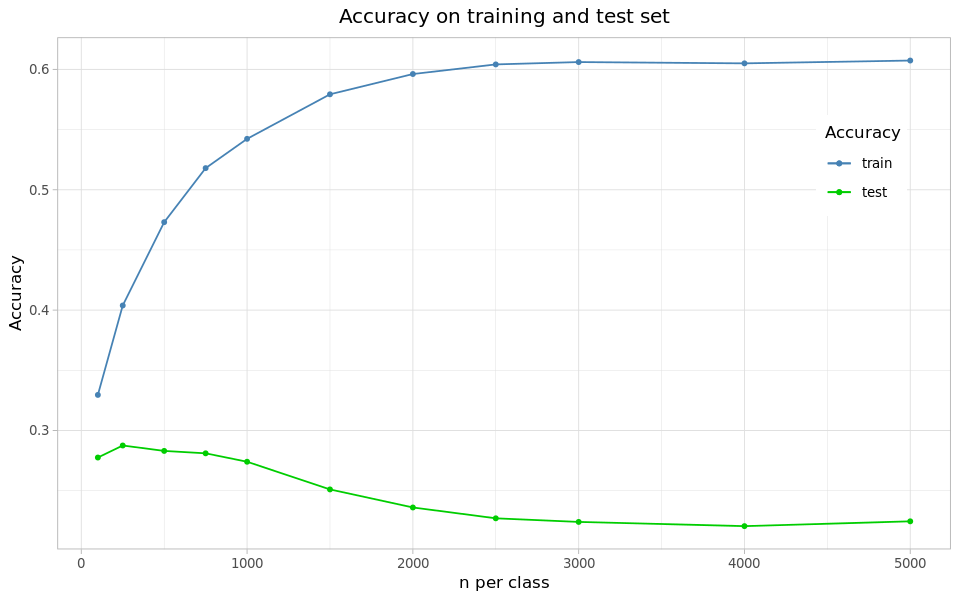

In [67]:
acc_df <- data.frame(n_perclass, train_accuracy, test_accuracy)
options(repr.plot.width=8, repr.plot.height=5)
plot_acc <- ggplot(data=acc_df)+
            theme_light() +
            geom_line(aes(x=n_perclass, y=train_accuracy, color="train")) +
            geom_line(aes(x=n_perclass, y=test_accuracy,  color="test"))  +
            geom_point(aes(x=n_perclass, y=train_accuracy, color="train"),size=1) +
            geom_point(aes(x=n_perclass, y=test_accuracy,  color="test"),size=1) +
            labs(x="n per class", y="Accuracy", title="Accuracy on training and test set")+
            theme(plot.title = element_text(hjust = 0.5),text = element_text(size=10),legend.position=c(.9,.75))+
            scale_color_manual(name = "Accuracy", values = c("train" = "steelblue", "test" = "green3"))
plot_acc

# ggsave("NaiveBayesMNC/Accuracy_plot.pdf",plot_acc,width = 10, height = 6)

confusion matrix on training set

In [68]:
mi_voc <- list()
mi_vocabulary <- vector()
N <- 3000
for(i in L) {
    mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N]
    mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N])
}
results_voc <- multinomNBC.voc.fit(df[1:nDoc, 2], df[1:nDoc, 1],voc=mi_vocabulary)
pred_voc <- multinomNBC.predict(df[1:nDoc, 2][[1]], results_voc$log.prior, results_voc$log.likelihood, results_voc$vocabulary)




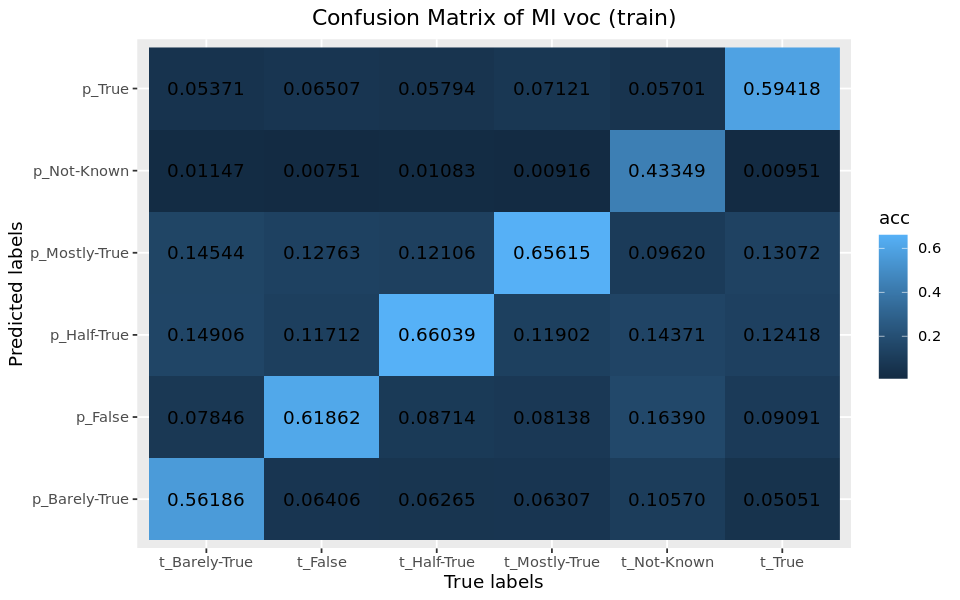

In [84]:
conf_matrix_MI_train <- confusion_matrix(pred_voc, df[1:nDoc, 1][[1]])
plt_train <- plot_confmat(conf_matrix_MI_train, "Confusion Matrix of MI voc (train)")
ggsave('conf_matrix_train_mifr.pdf', plt_train, width=7, height=6)
plt_train

Confusion matrix on test set

In [88]:
mi_voc <- list()
mi_vocabulary <- vector()
N <- 250
for(i in L) {
    mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N]
    mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N])
}
voc_train <- multinomNBC.voc.fit(df[test:nDoc, 2], df[test:nDoc, 1], mi_vocabulary)
voc_pred  <- multinomNBC.predict(df[1:test, 2][[1]], voc_train$log.prior, voc_train$log.likelihood, voc_train$vocabulary)

acc <- accuracy(voc_pred, df[1:test, 1][[1]])



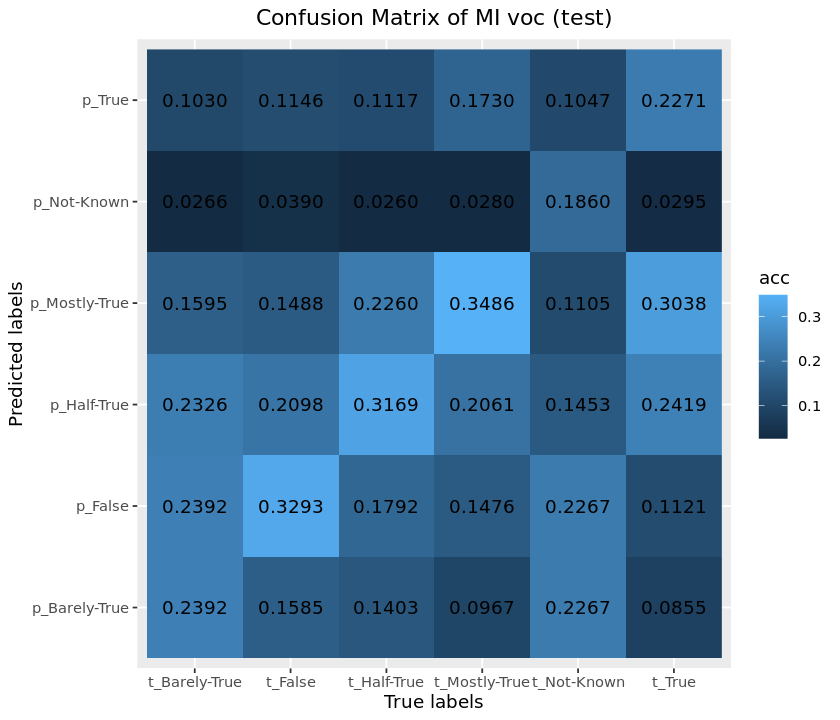

In [89]:
conf_matrix_MI_test <- confusion_matrix(voc_pred, df[1:test, 1][[1]])
plt_test <- plot_confmat(conf_matrix_MI_test, "Confusion Matrix of MI voc (test)")
ggsave('conf_matrix_test_mifr.pdf', plt_test, width=7, height=6)
plt_test

## Probability conditioned to tags


In [117]:
f_log.like.w_tc <- function(documents_l, tags_l, unique_tags,V, ...) {
    log.like.w_tc <- vector(mode='numeric', length=length(unique_tags))
    names(log.like.w_tc) <- unique_tags
    tag_mask <- Vectorize(grepl, 'pattern')(unique_tags, tags_l)
    
    log.like.w_tc <- Vectorize(function(t) {
            text <- extract_alnum(documents_l[tag_mask[,t]], unique=FALSE, ...)
            freq <- table(c(text, V))[V]
            log(freq) - log(sum(freq))
        }, 't')(unique_tags)
        
    return(log.like.w_tc)
}

multinomNBC_t.fit <- function(documents, labels, tags, V=NULL, ...) {
  
    # extract vocabulary, tags, and labels
    if(is.null(V)) {
        V <- extract_alnum(documents[[1]], ...)
    }
    all_tags <- str_extract_all(tags[[1]], '[:alnum:]+[-]?[:alnum:]*[-]?[:alnum:]*')
    unique_tags <- unique(unlist(all_tags))
    unique_labels <- unique(labels[[1]])

    #prior
    N <- length(documents[[1]])
    log.prior <- log(table(labels)) - log(N)
    #likelihood of word given tag and class
    dimnames.w_tc <- list(unique_labels, unique_tags, V)
    log.like.w_tc <- array(dim=c(length(unique_labels), length(unique_tags), length(V)), dimnames=dimnames.w_tc)
    #likelihood of tag given class
    dimnames.t_c <- list(unique_labels, unique_tags)
    log.like.t_c <- matrix(nrow=length(unique_labels), ncol=length(unique_tags), dimnames=dimnames.t_c)
    #prior for tags
    N_t <- length(unlist(all_tags))
    prior.t <- (table(unlist(all_tags)))/N_t

    for(l in unique_labels) {
        
        tags_l <- all_tags[labels==l]
        tag_freq <- table(c(unlist(tags_l), unique_tags))
        log.like.t_c[as.character(l), ] <- log(tag_freq) - log(sum(tag_freq))

        log.like.w_tc[as.character(l), , ] <- t(f_log.like.w_tc(documents[labels==l], tags_l, unique_tags, V, ...))
    }

    return(list(log.likelihood.w_tc=log.like.w_tc, log.likelihood.t_c=log.like.t_c, prior.t=prior.t, log.prior=log.prior, vocabulary=V[order(V)], tags=unique_tags))
}

multinomNBC_t.predict <- function(doc, tags, log.prior, log.likelihood.w_tc, log.likelihood.t_c, prior.t, voc, known_tags){

    text <- extract_alnum(doc, unique=FALSE)
    freq <- table(text)[voc]
    freq <- freq[!is.na(freq)]
    
    scores <- rep(0, length(log.prior))
    names(scores) <- dimnames(log.prior)$Labels

    tags_k <- known_tags #intersect(tags, known_tags)
    
    for( l in names(scores)) {
        w_ct <- log.likelihood.w_tc[l, tags_k, dimnames(freq)$text]
        sum_f <- ifelse(is.null(attr(w_ct, 'dim')), sum, rowSums)
        scores[l] <- log(sum(exp(log.prior[l] + sum_f( w_ct * rep(freq, each=length(tags_k))) + log.likelihood.t_c[l, tags_k])*prior.t[tags_k]))
    }
    
    return(names(scores)[which.max(scores)[[1]]])
}

multinomNBC_t.predict <- Vectorize(multinomNBC_t.predict, vectorize.args=c('doc'), USE.NAMES=FALSE)

In [111]:
nDoc <- dim(df)[1]
test <- 2000
results <- multinomNBC_t.fit(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], df[1:nDoc, 3])
cat('Prior of classes:\n')
exp(results$log.prior)

Prior of classes:


Labels
         0          1          2          3          4          5 
0.16023703 0.19446124 0.20776394 0.19252630 0.08029992 0.16471157 

In [112]:
cat('Conditioned probability of tags wrt classes:\n')
exp(results$log.likelihood.t_c)
cat('10 highest probability tags for fake news:\n')
tags_fake <- results$log.likelihood.t_c['1', ]
head(exp(tags_fake[order(tags_fake, decreasing=TRUE)]), 10)

Conditioned probability of tags wrt classes:


,abortion,energy,history,job-accomplishments,foreign-policy,health-care,economy,jobs,education,candidates-biography,...,30,m,since,George,Bush,took,office,goes,insurance,companies
1,0.0006514658,0.0002171553,0.0002171553,0.0002171553,0.0002171553,0.0002171553,0.0002171553,0.0002171553,0.0002171553,0.0017372421,...,0.008034745,0.002388708,0.001737242,0.001520087,0.002171553,0.0004343105,0.0002171553,0.007166124,0.011292074,0.0002171553
2,0.0004044489,0.0002022245,0.0002022245,0.0002022245,0.0002022245,0.0002022245,0.0002022245,0.0002022245,0.0002022245,0.0004044489,...,0.007886754,0.002831143,0.003033367,0.001415571,0.001617796,0.0002022245,0.0002022245,0.008493428,0.011931244,0.0002022245
3,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0017043034,...,0.007030251,0.003195569,0.003195569,0.001704303,0.004686834,0.0002130379,0.0004260758,0.010438858,0.015338730,0.0002130379
5,0.0002653224,0.0005306447,0.0005306447,0.0002653224,0.0002653224,0.0002653224,0.0005306447,0.0002653224,0.0002653224,0.0031838684,...,0.009020960,0.001857257,0.002653224,0.001857257,0.001591934,0.0002653224,0.0002653224,0.009020960,0.013796763,0.0005306447
0,0.0007826768,0.0002608923,0.0002608923,0.0005217845,0.0002608923,0.0005217845,0.0002608923,0.0005217845,0.0005217845,0.0023480303,...,0.012522828,0.001826246,0.003391599,0.002608923,0.001826246,0.0002608923,0.0002608923,0.011740151,0.013827289,0.0002608923
4,0.0004987531,0.0004987531,0.0004987531,0.0004987531,0.0009975062,0.0004987531,0.0004987531,0.0004987531,0.0004987531,0.0009975062,...,0.006982544,0.002493766,0.001496259,0.001496259,0.003990025,0.0004987531,0.0004987531,0.008478803,0.005985037,0.0004987531


10 highest probability tags for fake news:


privacy         disability       successfully              ebola 
        0.05407166         0.04169381         0.04060803         0.03192182 
               one            debates            pundits      Wisconsinites 
        0.03170467         0.03018458         0.02866450         0.02844734 
florida-amendments            nuclear 
        0.02453855         0.02345277

In [113]:
pred_test <- multinomNBC_t.predict(df[(nDoc-test+1):nDoc, 2][[1]], unlist(str_extract_all(df[(nDoc-test+1):nDoc, 3][[1]], '[:alnum:]+[-]?[:alnum:]*[-]?[:alnum:]*')), results$log.prior, results$log.likelihood.w_tc, results$log.likelihood.t_c, results$prior.t, results$vocabulary, results$tags)

In [115]:
pred_train <- multinomNBC_t.predict(df[1:(nDoc-test), 2][[1]], unlist(str_extract_all(df[1:(nDoc-test), 3][[1]], '[:alnum:]+[-]?[:alnum:]*[-]?[:alnum:]*')), results$log.prior, results$log.likelihood.w_tc, results$log.likelihood.t_c, results$prior.t, results$vocabulary, results$tags)

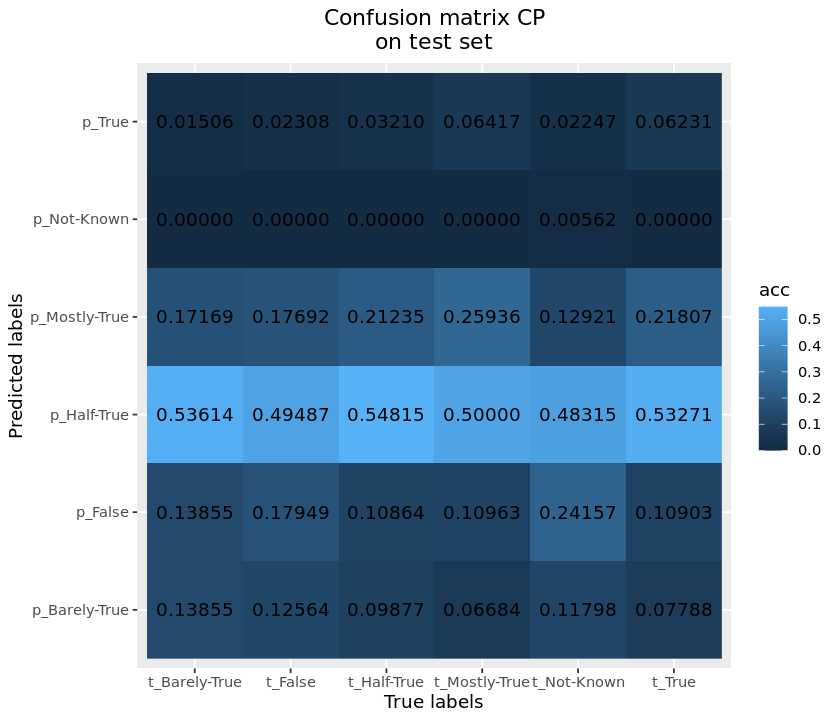

In [114]:
conf_mat_test_CP <- confusion_matrix(pred_test, df[(nDoc-test+1):nDoc, 1][[1]])
plt_test <- plot_confmat(conf_mat_test_CP, 'Confusion matrix CP\non test set')
plt_test
#ggsave('conf_matrix_test_CP.pdf', plt_test, width=7, height=6)

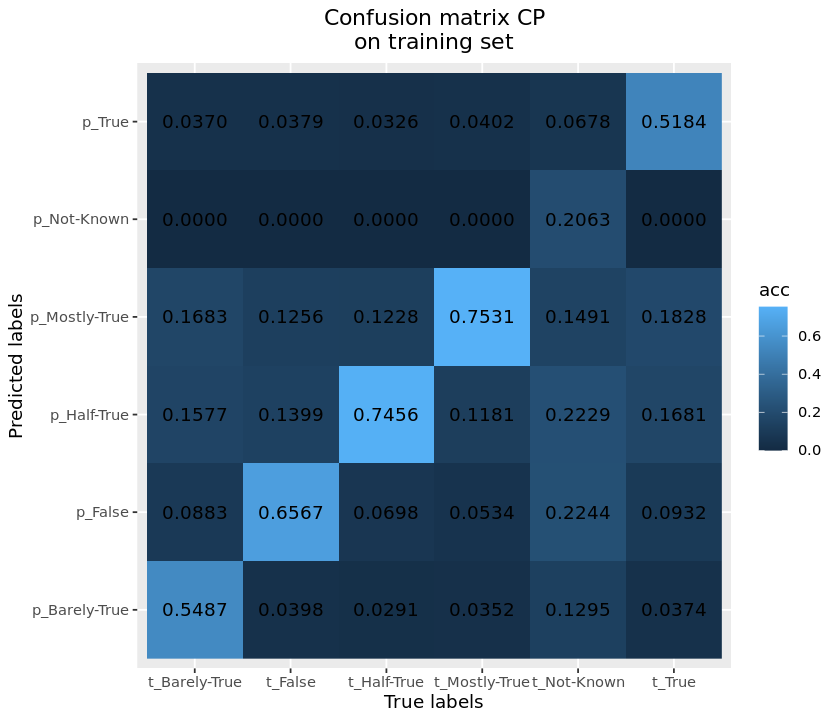

In [116]:
conf_mat_train <- confusion_matrix(pred_train, df[1:(nDoc-test), 1][[1]])
plt_train <- plot_confmat(conf_mat_train, 'Confusion matrix CP\non training set')
plt_train
#ggsave('conf_matrix_train_CP.pdf', plt_train, width=7, height=6)

### Combine Mutual information with conditioned probability

In [69]:
mi_voc_test <- list()
mi_voc_train <- list()
mi_vocabulary_test <- vector()
mi_vocabulary_train <- vector()
N_test <- 250
N_train <- 250
for(i in L) {
    mi_voc_test[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N_test]
    mi_vocabulary_test <- union(mi_vocabulary_test, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N_test])
    mi_voc_train[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N_train]
    mi_vocabulary_train <- union(mi_vocabulary_train, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:N_train])
}

In [70]:
nDoc <- dim(df)[1]
test <- 2000
results <- multinomNBC_t.fit(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], df[1:nDoc, 3], V=mi_vocabulary_train)
exp(results$log.prior)

Labels
         0          1          2          3          4          5 
0.16023703 0.19446124 0.20776394 0.19252630 0.08029992 0.16471157 

In [71]:
pred_test <- multinomNBC_t.predict(df[(nDoc-test+1):nDoc, 2][[1]], unlist(str_extract_all(df[(nDoc-test+1):nDoc, 3][[1]], '[:alnum:]+[-]?[:alnum:]*[-]?[:alnum:]*')), results$log.prior, results$log.likelihood.w_tc, results$log.likelihood.t_c, results$prior.t,results$vocabulary, results$tags)

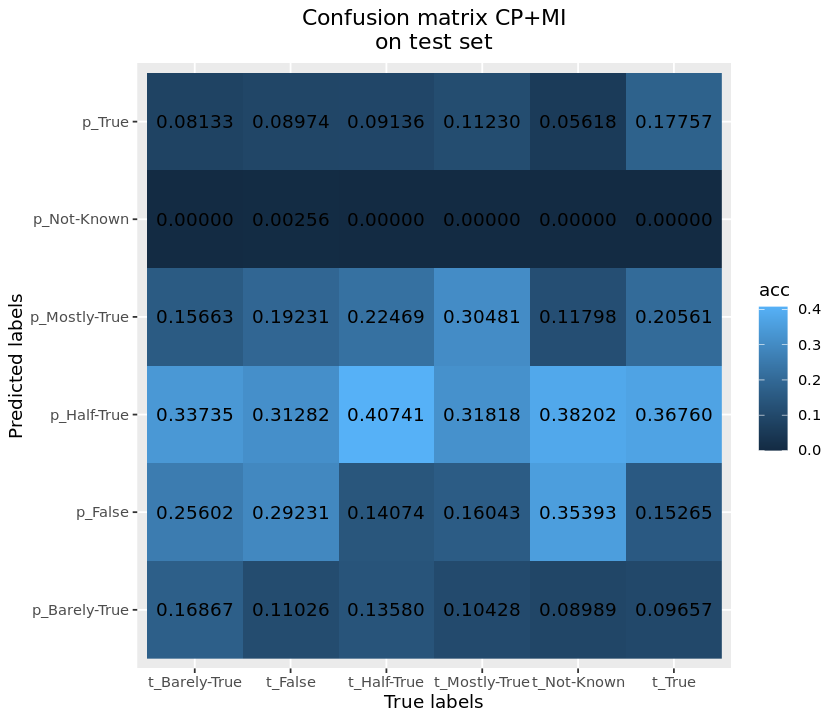

In [72]:
conf_mat_test_CPMI <- confusion_matrix(pred_test, df[(nDoc-test+1):nDoc, 1][[1]])
plt_test <- plot_confmat(conf_mat_test_CPMI, 'Confusion matrix CP+MI\non test set')
plt_test
#ggsave('conf_matrix_test_CPMI_u.pdf', plt_test, width=7, height=6)

In [61]:
pred_train <- multinomNBC_t.predict(df[1:(nDoc-test), 2][[1]], unlist(str_extract_all(df[1:(nDoc-test), 3][[1]], '[:alnum:]+[-]?[:alnum:]*[-]?[:alnum:]*')), results$log.prior, results$log.likelihood.w_tc, results$log.likelihood.t_c, results$prior.t, results$vocabulary, results$tags)

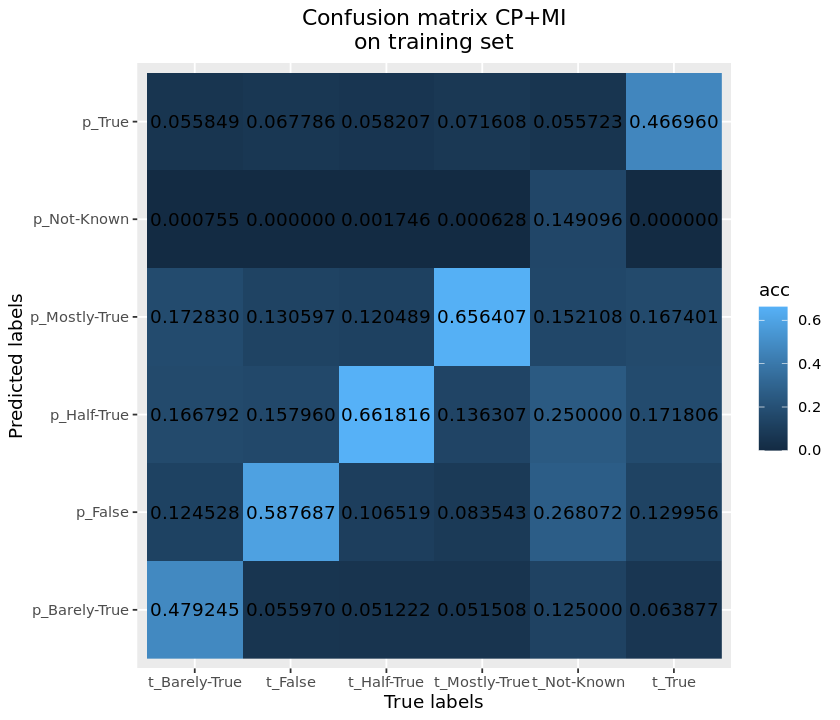

In [62]:
conf_mat_train <- confusion_matrix(pred_train, df[1:(nDoc-test), 1][[1]])
plt_train <- plot_confmat(conf_mat_train, 'Confusion matrix CP+MI\non training set')
plt_train
#ggsave('conf_matrix_train_CPMI_u.pdf', plt_train, width=7, height=6)

## Conclusion

In [101]:
data_plt <- data.frame(x=c('Simple', 'NFR', 'MI', 'CP', 'CPMI'), 
                       true=rep(NA, 5), nk=rep(NA, 5), mt=rep(NA, 5), ht=rep(NA, 5), false=rep(NA, 5), bt=rep(NaN, 5), overall=rep(NA, 5))

data_plt[1, -c(1,8)] <- diag(conf_mat_s)
data_plt[2, -c(1,8)] <- diag(conf_matrix_test_nfr)
data_plt[3, -c(1,8)] <- diag(conf_matrix_MI_test)
data_plt[4, -c(1,8)] <- diag(conf_mat_test_CP)
data_plt[5, -c(1,8)] <- diag(conf_mat_test_CPMI)
data_plt[, 8] <- rowSums(data_plt[,-1], na.rm=TRUE)

data_plt <- data_plt %>% pivot_longer(., cols=colnames(.)[-1], names_to='doc_class', values_to='acc')

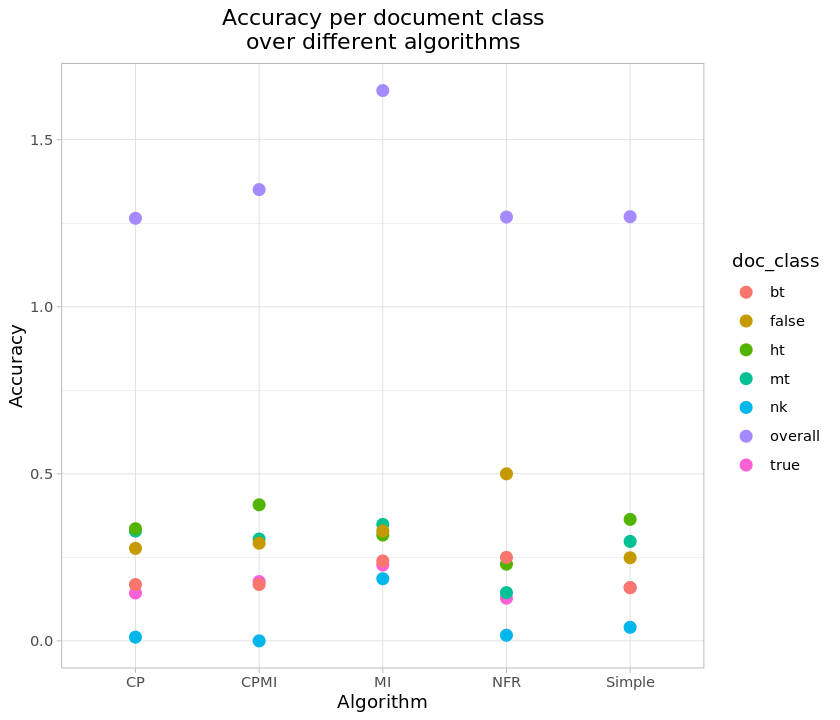

In [109]:
plt <- ggplot(data_plt, aes(x=x, y=acc, color=doc_class)) +
       geom_point(size=3) +
       theme_light() +
       labs(title='Accuracy per document class\nover different algorithms',
            x='Algorithm', y='Accuracy') +
       theme(plot.title=element_text(hjust=0.5))

plt
ggsave('NaiveBayesMNC/images/overall.pdf', plt, width=7, height=6)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc46254b-f6ba-40ca-a8f2-21d26c54dddd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>